# Does increased sequencing significantly rescue variant loss when thresholding for minimum counts in no-antibody infections?



Import Python modules:

In [1]:
import os

import altair as alt

import dms_variants
import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from plotnine import *

_ = theme_set(dms_variants.plotnine_themes.theme_graygrid())

import pandas as pd

import yaml

import warnings
warnings.filterwarnings('ignore')

In [2]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

Get configuration information:

In [3]:
os.chdir('../../')

with open("config.yaml") as f:
    config = yaml.safe_load(f)

## Read the escape probabilities and neutralization information
Get the antibody selections data frame:

In [4]:
antibody_selections = pd.read_csv(config["antibody_selections"])

Read in the probabilities of escape and neutralization information:

In [5]:
selection_groups = antibody_selections["selection_group"].unique()

prob_escape = pd.concat(
    [
        pd.read_csv(
            os.path.join(
                config["prob_escape_dir"], f"{selection_group}_prob_escape.csv"
            ),
            keep_default_na=False,
            na_values="nan",
        )
        for selection_group in selection_groups
    ],
    ignore_index=True,
)

### Variants with sufficient no-antibody counts
We only calculate the probability of escape for variants with some minimum threshold of no-antibody counts.

Get a df of samples for each selection and label whether they pass the minimum threshold for their corresponding no-antibody sample

In [6]:
# get data to plot
no_ab_counts = (
    prob_escape[
        [
            "library",
            "no-antibody_sample",
            "aa_substitutions_sequential",
            "no-antibody_count",
            "barcode",
            "no_antibody_count_threshold",
        ]
    ]
    .drop_duplicates()
    .assign(
        variant_above_threshold=lambda x: (
            x["no-antibody_count"] >= x["no_antibody_count_threshold"]
        ).astype(int),
        count_above_threshold=lambda x: x["no-antibody_count"]
        * x["variant_above_threshold"],
    ))

no_ab_counts['sample'] = no_ab_counts['library'] + '_' + no_ab_counts['no-antibody_sample']

### Reduce to seq data for no-antibody infections from AUSAB-13 selection samples

Filter to just samples from 220606 and 220711 sequencing runs. Note that these are the exact same samples, but 220606 was a P2 sequencing run while 220711 was a P3 run.

In [131]:
no_ab_counts['date'] = no_ab_counts['no-antibody_sample'].str.split('_', expand=True)[0]

ausab13_full_seq = no_ab_counts[(no_ab_counts['date'] == '220606') |
                                (no_ab_counts['date'] == '220711')]

ausab13_full_seq

,library,no-antibody_sample,aa_substitutions_sequential,no-antibody_count,barcode,no_antibody_count_threshold,variant_above_threshold,count_above_threshold,sample,date
1062005,libA,220606_1_no-antibody_control_1,K297I,95250,ATAACACAAAAAAGTA,20,1,95250,libA_220606_1_no-antibody_control_1,220606
1062006,libA,220606_1_no-antibody_control_1,Y113N T150K L263H V342Y,28477,AGACACTAAATACAGC,20,1,28477,libA_220606_1_no-antibody_control_1,220606
1062007,libA,220606_1_no-antibody_control_1,K46A I301V E409M,28101,AAAAATCTGAGACAAA,20,1,28101,libA_220606_1_no-antibody_control_1,220606
1062008,libA,220606_1_no-antibody_control_1,,27169,AGCCTATTAGGATTCG,20,1,27169,libA_220606_1_no-antibody_control_1,220606
1062009,libA,220606_1_no-antibody_control_1,R111S V366M R402S,24512,TATCTACCTAACGAAA,20,1,24512,libA_220606_1_no-antibody_control_1,220606
...,...,...,...,...,...,...,...,...,...,...
2238614,libB,220711_1_no-antibody_control_1,V107I T179F S238Q,0,TTTTTGTGGGGTCTTC,20,0,0,libB_220711_1_no-antibody_control_1,220711
2238615,libB,220711_1_no-antibody_control_1,Y119H I211K S212L,0,TTTTTTAAATTAATCC,20,0,0,libB_220711_1_no-antibody_control_1,220711
2238616,libB,220711_1_no-antibody_control_1,S157F G161S S212G R239F,0,TTTTTTCGATAGTCCT,20,0,0,libB_220711_1_no-antibody_control_1,220711
2238617,libB,220711_1_no-antibody_control_1,N152S H175A I211D Q216S K297F D310Q,0,TTTTTTTAAGACAAAC,20,0,0,libB_220711_1_no-antibody_control_1,220711


Reduce to single full set of barcode variants per library, with columns listing number of barcode counts for P2 (220606), P3 (220711), and P2+P3 combined sequencing runs. 

In [165]:
ausab13_merged_runs = (ausab13_full_seq
                       .pivot(
                           index=['library', 'aa_substitutions_sequential', 'barcode'],
                           columns='date',
                           values='no-antibody_count'
                       )
                       .reset_index()
                       .rename_axis(None, axis=1)
                      )

ausab13_merged_runs = ausab13_merged_runs.rename(
    columns={'220606': 'P2', 
             '220711': 'P3'}
)

ausab13_merged_runs['combined'] = ausab13_merged_runs['P2'] + ausab13_merged_runs['P3']

ausab13_merged_runs = ausab13_merged_runs.melt(
    id_vars = ['library', 'aa_substitutions_sequential', 'barcode'],
    value_vars = ['P2', 'P3', 'combined'],
    var_name = 'seq_run',
    value_name = 'counts'
)

ausab13_merged_runs

,library,aa_substitutions_sequential,barcode,seq_run,counts
0,libA,,AAAAAAAAAAATCCTT,P2,0
1,libA,,AAAAAAAATACATATG,P2,3
2,libA,,AAAAAAAATTGCTCAC,P2,3
3,libA,,AAAAAAATTCTGTATA,P2,274
4,libA,,AAAAAATCAGTTTTAC,P2,0
...,...,...,...,...,...
455140,libB,Y505H,ATTTAGTCATTACTTA,combined,0
455141,libB,Y505H,CGGTACGCAGGGTGTA,combined,0
455142,libB,Y505H,TAGAGATGAAATGACA,combined,0
455143,libB,Y505H D512Q,CTTGTTACGGTATTCA,combined,0


### Add data on valid barcode reads per sample

In [166]:
libs = ['libA', 'libB']
runs = ['220606', '220711']
valid_bc_counts = {}

for lib in libs:
    for run in runs:
        bc_fates = pd.read_csv(f'results//barcode_runs/fates_by_sample/{lib}_{run}_1_no-antibody_control_1.csv')
        valid_count = bc_fates[bc_fates['fate']=='valid barcode']['count'].iloc[0]
        
        valid_bc_counts[f'{lib}_{run}'] = valid_count

    valid_bc_counts[f'{lib}_combined'] = valid_bc_counts[f'{lib}_{runs[0]}'] + valid_bc_counts[f'{lib}_{runs[1]}']

valid_bc_counts

{'libA_220606': 4067538,
 'libA_220711': 14877636,
 'libA_combined': 18945174,
 'libB_220606': 3127660,
 'libB_220711': 12354871,
 'libB_combined': 15482531}

In [167]:
valid_bc_counts_df = (pd.DataFrame
                      .from_dict(
                          valid_bc_counts, 
                          orient='index', 
                          columns=['valid_bc_counts'])
                      .reset_index(level=0)
                      .rename(columns={'index':'sample'})
                     )

valid_bc_counts_df[['library', 'seq_run']] = valid_bc_counts_df['sample'].str.split('_', expand=True)

seq_run_mapping = {'220606': 'P2', '220711': 'P3'}

valid_bc_counts_df = valid_bc_counts_df.replace({'seq_run': seq_run_mapping}).drop(['sample'], axis=1)

valid_bc_counts_df

,valid_bc_counts,library,seq_run
0,4067538,libA,P2
1,14877636,libA,P3
2,18945174,libA,combined
3,3127660,libB,P2
4,12354871,libB,P3
5,15482531,libB,combined


In [168]:
ausab13_full = ausab13_merged_runs.merge(
    valid_bc_counts_df,
    on=['library', 'seq_run'],
    how='left'
)

ausab13_full['number_substitutions'] = ausab13_full.apply(
    lambda x: len(x['aa_substitutions_sequential'].split()), axis=1
)

ausab13_full

,library,aa_substitutions_sequential,barcode,seq_run,counts,valid_bc_counts,number_substitutions
0,libA,,AAAAAAAAAAATCCTT,P2,0,4067538,0
1,libA,,AAAAAAAATACATATG,P2,3,4067538,0
2,libA,,AAAAAAAATTGCTCAC,P2,3,4067538,0
3,libA,,AAAAAAATTCTGTATA,P2,274,4067538,0
4,libA,,AAAAAATCAGTTTTAC,P2,0,4067538,0
...,...,...,...,...,...,...,...
455140,libB,Y505H,ATTTAGTCATTACTTA,combined,0,15482531,1
455141,libB,Y505H,CGGTACGCAGGGTGTA,combined,0,15482531,1
455142,libB,Y505H,TAGAGATGAAATGACA,combined,0,15482531,1
455143,libB,Y505H D512Q,CTTGTTACGGTATTCA,combined,0,15482531,2


In [183]:
sufficient_counts = ausab13_full.loc[(ausab13_merged_runs['counts'] >= 20)].reset_index(drop=True)

stratified_thresholded_variants = (sufficient_counts.groupby(['number_substitutions', 'seq_run', 'library', 'valid_bc_counts'])
                                   .size()
                                   .reset_index(name='thresholded_variants'))


stratified_thresholded_variants.head()

,number_substitutions,seq_run,library,valid_bc_counts,thresholded_variants
0,0,P2,libA,4067538,1314
1,0,P2,libB,3127660,1845
2,0,P3,libA,14877636,1811
3,0,P3,libB,12354871,2981
4,0,combined,libA,18945174,1872


In [184]:
pacbio_total = (ausab13_full.groupby(['number_substitutions', 'seq_run', 'library'])
                .size()
                .reset_index(name='pacbio_lib_size')
               )

ausab13_strat_var = stratified_thresholded_variants.merge(
    pacbio_total,
    how='left',
    on=['number_substitutions', 'seq_run', 'library']
)

ausab13_strat_var['fraction_pacbio'] = (ausab13_strat_var['thresholded_variants'] 
                                        / ausab13_strat_var['pacbio_lib_size'])

ausab13_strat_var = ausab13_strat_var.loc[ausab13_strat_var['number_substitutions'] < 9]

ausab13_strat_var.head()

,number_substitutions,seq_run,library,valid_bc_counts,thresholded_variants,pacbio_lib_size,fraction_pacbio
0,0,P2,libA,4067538,1314,2244,0.585561
1,0,P2,libB,3127660,1845,4597,0.401349
2,0,P3,libA,14877636,1811,2244,0.807041
3,0,P3,libB,12354871,2981,4597,0.648466
4,0,combined,libA,18945174,1872,2244,0.834225


In [193]:
from mizani.formatters import scientific_format

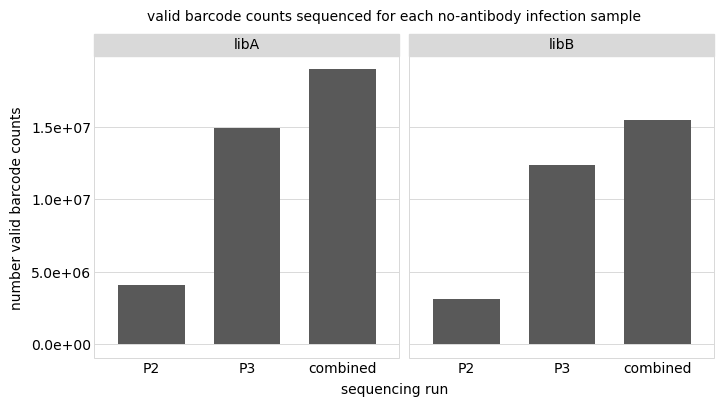

In [195]:
ausab13_wt = ausab13_strat_var.loc[ausab13_strat_var['number_substitutions'] == 0]

p = (
    ggplot(
        ausab13_wt,
        aes(x='seq_run',
            y='valid_bc_counts'
        )
    ) +
    geom_bar(stat='identity', width=0.7) +
    theme(figure_size=(8, 4),
         panel_grid_major_x=element_blank(),
         ) + 
    scale_fill_manual(values=CBPALETTE[2:]) +
    scale_y_continuous(labels=scientific_format(digits=2)) +
    labs(x='sequencing run', 
         y='number valid barcode counts',
         title='valid barcode counts sequenced for each no-antibody infection sample'
        )
)

p = p + facet_wrap('~ library', nrow = 1)

_ = p.draw()

p.save('scratch_notebooks/220614_variant_dropout_analysis/figures/bc_counts_per_sample.pdf')

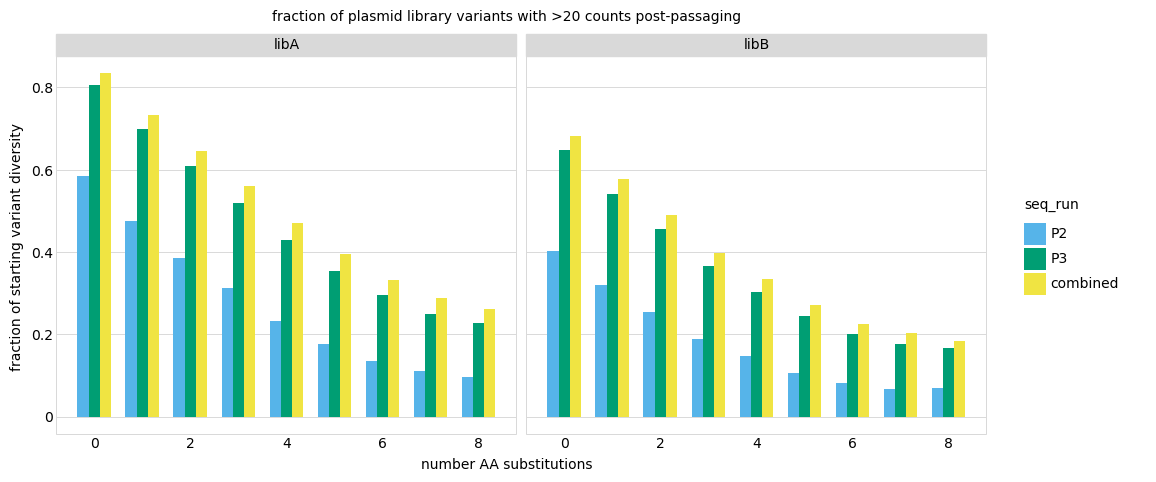

In [196]:
p = (
    ggplot(
        ausab13_strat_var,
        aes(x='number_substitutions', 
            y='fraction_pacbio', 
            fill='seq_run'
           )
    ) +
    geom_bar(stat='identity', position=position_dodge(), width=0.7) +
    theme(figure_size=(12, 5),
         panel_grid_major_x=element_blank(),
         ) + 
    scale_fill_manual(values=CBPALETTE[2:]) +
    labs(x='number AA substitutions', 
         y='fraction of starting variant diversity', 
         title='fraction of plasmid library variants with >20 counts post-passaging')
)

p = p + facet_wrap('~ library', nrow = 1)

_ = p.draw()

p.save('scratch_notebooks/220614_variant_dropout_analysis/figures/fraction_retained_variants_p3_seq.pdf')

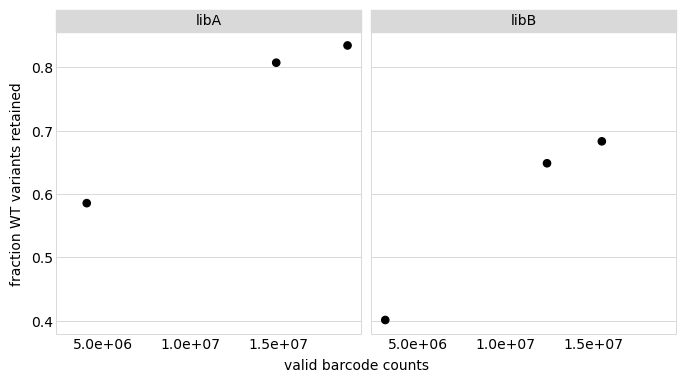

In [205]:
p = (
    ggplot(
        ausab13_wt,
        aes(x='valid_bc_counts',
            y='fraction_pacbio'
        )
    ) +
    geom_point(stat='identity', size=2.5) +
    theme(figure_size=(8, 4),
          panel_grid_major_x=element_blank(),
         ) + 
    scale_x_continuous(labels=scientific_format(digits=2)) +
    labs(x='valid barcode counts', 
         y='fraction WT variants retained')
)

p = p + facet_wrap('~ library', nrow = 1)

_ = p.draw()

p.save('scratch_notebooks/220614_variant_dropout_analysis/figures/wt_retained_vs_seq_counts.pdf')